# WP1 - Anomaly subgraph extraction: Finding anomalies

In [7]:
import py2neo
import pandas as pd
import numpy as np
from spot import bidSPOT, dSPOT,  SPOT
import traceback
from statsmodels.tsa.stattools import grangercausalitytests

In [3]:
graph = py2neo.Graph("bolt://192.168.1.185:7687", auth=("neo4j", "hpi"))

In [6]:
full_data = pd.read_csv('../data/loadtest-timestamp.csv', index_col=0)
full_data[['Date', 'Time']] = full_data['Time'].str.split(" ", expand=True)
full_data = full_data.sort_values(by=['Date','Time'])
full_data

,Time,carts,carts-db,catalogue,catalogue-db,front-end,orders,orders-db,payment,queue-master,rabbitmq,session-db,shipping,user,user-db,Date
674,11:27,0.00245,0.00824,0.00129,0.001150,0.00313,0.00260,0.00901,0.001250,0.00254,0.0145,0.00232,0.00223,0.00178,0.00942,10/14/2021
675,11:28,0.00279,0.01020,0.00128,0.001080,0.00352,0.00273,0.00974,0.001310,0.00249,0.0136,0.00268,0.00235,0.00191,0.01060,10/14/2021
676,11:29,0.00345,0.00929,0.00140,0.001180,0.00379,0.00262,0.00938,0.001370,0.00329,0.0132,0.00260,0.00214,0.00198,0.01020,10/14/2021
677,11:30,0.00233,0.00890,0.00108,0.001120,0.00343,0.00227,0.00783,0.001300,0.00239,0.0113,0.00223,0.00221,0.00173,0.00869,10/14/2021
678,11:31,0.00421,0.00914,0.00148,0.001380,0.00405,0.00297,0.00980,0.001410,0.00250,0.0127,0.00259,0.00234,0.00233,0.01030,10/14/2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,20:33,0.00312,0.01000,0.00139,0.000967,0.00300,0.00320,0.00924,0.001150,0.00214,0.0152,0.00238,0.00187,0.00234,0.00920,3/2/2022
528,20:34,0.00252,0.01080,0.00116,0.001060,0.00311,0.00259,0.01050,0.001480,0.00210,0.0118,0.00260,0.00220,0.00195,0.00965,3/2/2022
529,20:35,0.00311,0.01030,0.00134,0.001460,0.00366,0.00278,0.01060,0.001330,0.00222,0.0122,0.00247,0.00271,0.00237,0.01090,3/2/2022
530,20:36,0.00220,0.01030,0.00102,0.000994,0.00334,0.00458,0.00998,0.000969,0.00222,0.0128,0.00241,0.00213,0.00180,0.00955,3/2/2022


In [30]:
# Prepare data
u_data = (full_data['Date'] == '2/17/2022')| (full_data['Date'] == '3/2/2022')
all_data = full_data[u_data]
# initial batch
u_init_data = (full_data['Date'] == '10/14/2021') | (full_data['Date'] == '10/20/2021')| (full_data['Date'] == '10/19/2021')
all_init_data = full_data[u_init_data]

csv_nodes = full_data.columns.drop(['Date', 'Time'])
print("Node names from data csv: ", sorted(csv_nodes))
graph_nodes = [node['id'] for node in graph.nodes.match().all()]
print("Node names from graph: ", sorted(graph_nodes))
print("Nodes in graph but not in data csv: ", sorted(set(graph_nodes) - set(csv_nodes)))
print("Nodes in data csv but not in graph: ", sorted(set(csv_nodes) - set(graph_nodes)))
for column_name in csv_nodes:
    init_data = all_init_data[column_name].to_numpy()
    data = all_data[column_name].to_numpy()

    try:
        q = 1e-5  			# risk parameter
        s = SPOT(q)  		# SPOT object
        s.fit(init_data,data) 	# data import
        s.initialize(verbose=False) 		# initialization step
        results = s.run() 	# run
        #s.plot(results) 	# plot
        alarms = results["alarms"]
        node = graph.nodes.match(id=column_name).first()
        if len(alarms) > 0:
            node_id = node["id"]
            print(node_id)
            print(f"had an anomaly, first at {alarms[0]}")
            for node_2_id in csv_nodes:
                if node_2_id == node_id:
                    continue
                gc_dicts = grangercausalitytests(full_data[[node_id, node_2_id]], 2, verbose=False)
                p_values = [lag_result[0]['ssr_chi2test'][1] for lag_result in gc_dicts.values()]

                gc_dicts_after_anomaly = grangercausalitytests(full_data[[node_id, node_2_id]].iloc[alarms[-1]:], 2, verbose=False)
                p_values_after_anomaly  = [lag_result[0]['ssr_chi2test'][1] for lag_result in gc_dicts_after_anomaly .values()]

                if (np.min(p_values) < 0.05) != (np.min(p_values_after_anomaly) < 0.05):
                    print(node_2_id)
                    print(f"Test outputs differ: {np.min(p_values) < 0.05} whole time series and {np.min(p_values_after_anomaly) < 0.05} after anomaly")
                    print(f"Anomaly cut-off was after index {alarms[-1]} of {len(full_data)}")
            #node["anomaly"] = True
            #graph.push(node)
        #else:
            #node["anomaly"] = False
            # graph.push(node)
    except Exception:
            print(traceback.format_exc())


Node names from data csv:  ['carts', 'carts-db', 'catalogue', 'catalogue-db', 'front-end', 'orders', 'orders-db', 'payment', 'queue-master', 'rabbitmq', 'session-db', 'shipping', 'user', 'user-db']
Node names from graph:  ['carts', 'carts-db', 'catalogue', 'catalogue-db', 'front-end', 'master', 'orders', 'orders-db', 'payment', 'queue-master', 'rabbitmq', 'session-db', 'shipping', 'user', 'user-db', 'worker1', 'worker2']
Nodes in graph but not in data csv:  ['master', 'worker1', 'worker2']
Nodes in data csv but not in graph:  []


100%|██████████| 589/589 [00:00<00:00, 716.54it/s] 


carts
had an anomaly, first at 6
rabbitmq
Test outputs differ: True whole time series and False after anomaly
Anomaly cut-off was after index 543 of 813


100%|██████████| 589/589 [00:00<00:00, 904.07it/s] 


carts-db
had an anomaly, first at 152


100%|██████████| 589/589 [00:00<00:00, 12999.26it/s]


catalogue-db
had an anomaly, first at 86


100%|██████████| 589/589 [00:00<00:00, 1134.00it/s]


front-end
had an anomaly, first at 60
rabbitmq
Test outputs differ: True whole time series and False after anomaly
Anomaly cut-off was after index 419 of 813


100%|██████████| 589/589 [00:00<00:00, 1427.01it/s]


orders
had an anomaly, first at 7
catalogue
Test outputs differ: True whole time series and False after anomaly
Anomaly cut-off was after index 542 of 813
catalogue-db
Test outputs differ: True whole time series and False after anomaly
Anomaly cut-off was after index 542 of 813


100%|██████████| 589/589 [00:00<00:00, 1698.12it/s]


orders-db
had an anomaly, first at 83
carts
Test outputs differ: True whole time series and False after anomaly
Anomaly cut-off was after index 532 of 813
catalogue-db
Test outputs differ: False whole time series and True after anomaly
Anomaly cut-off was after index 532 of 813
orders
Test outputs differ: True whole time series and False after anomaly
Anomaly cut-off was after index 532 of 813
rabbitmq
Test outputs differ: True whole time series and False after anomaly
Anomaly cut-off was after index 532 of 813


100%|██████████| 589/589 [00:00<00:00, 3111.06it/s]


payment
had an anomaly, first at 126


100%|██████████| 589/589 [00:00<00:00, 721.01it/s] 


queue-master
had an anomaly, first at 7
catalogue
Test outputs differ: True whole time series and False after anomaly
Anomaly cut-off was after index 539 of 813
orders
Test outputs differ: True whole time series and False after anomaly
Anomaly cut-off was after index 539 of 813
rabbitmq
Test outputs differ: True whole time series and False after anomaly
Anomaly cut-off was after index 539 of 813


100%|██████████| 589/589 [00:01<00:00, 321.80it/s]


rabbitmq
had an anomaly, first at 59
carts-db
Test outputs differ: True whole time series and False after anomaly
Anomaly cut-off was after index 542 of 813
catalogue
Test outputs differ: True whole time series and False after anomaly
Anomaly cut-off was after index 542 of 813
orders-db
Test outputs differ: True whole time series and False after anomaly
Anomaly cut-off was after index 542 of 813
payment
Test outputs differ: True whole time series and False after anomaly
Anomaly cut-off was after index 542 of 813
session-db
Test outputs differ: True whole time series and False after anomaly
Anomaly cut-off was after index 542 of 813
user
Test outputs differ: True whole time series and False after anomaly
Anomaly cut-off was after index 542 of 813
user-db
Test outputs differ: True whole time series and False after anomaly
Anomaly cut-off was after index 542 of 813


100%|██████████| 589/589 [00:00<00:00, 18132.11it/s]


session-db
had an anomaly, first at 92


100%|██████████| 589/589 [00:00<00:00, 3629.68it/s]


shipping
had an anomaly, first at 64
carts
Test outputs differ: True whole time series and False after anomaly
Anomaly cut-off was after index 543 of 813
catalogue-db
Test outputs differ: True whole time series and False after anomaly
Anomaly cut-off was after index 543 of 813


100%|██████████| 589/589 [00:00<00:00, 2546.41it/s]

Traceback (most recent call last):
  File "C:\Users\andrea\AppData\Local\Temp\ipykernel_28784\1127218371.py", line 22, in <cell line: 14>
    s.initialize(verbose=False) 		# initialization step
  File "c:\Users\Andrea1\Documents\HPI\MLGraphs\Spatio-Temporal-Graphs\src\spot.py", line 199, in initialize
    g,s,l = self._grimshaw()
  File "c:\Users\Andrea1\Documents\HPI\MLGraphs\Spatio-Temporal-Graphs\src\spot.py", line 345, in _grimshaw
    right_zeros = SPOT._rootsFinder(lambda t: w(self.peaks,t),
  File "c:\Users\Andrea1\Documents\HPI\MLGraphs\Spatio-Temporal-Graphs\src\spot.py", line 238, in _rootsFinder
    X0 = np.arange(bounds[0]+step,bounds[1],step)
ValueError: arange: cannot compute length




c:\Users\Andrea1\Documents\HPI\MLGraphs\Spatio-Temporal-Graphs\src\spot.py:238: RuntimeWarning: invalid value encountered in double_scalars
  X0 = np.arange(bounds[0]+step,bounds[1],step)


In [24]:
(np.min([1,2]) < 0.05) == (np.min([1,2]) < 0.05)

True

['carts',
 'user',
 'user-db',
 'catalogue',
 'catalogue-db',
 'orders-db',
 'carts-db',
 'queue-master',
 'rabbitmq',
 'session-db',
 'master',
 'worker1',
 'worker2',
 'front-end',
 'orders',
 'shipping',
 'payment']

Initial threshold : 0.0115
Number of peaks : 4
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.29489623181763014
	σ = 0.0008983580938078887
	L = 25.23935213122546
Extreme quantile (probability = 1e-05): 0.014211516462822898


100%|██████████| 589/589 [00:00<00:00, 784.54it/s] 


had an anomaly


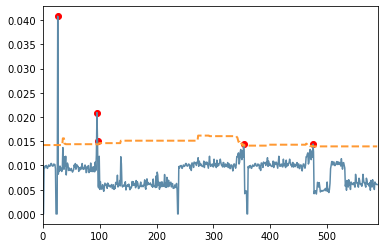

In [9]:
f = '../data/loadtest-Updated.csv'
P = pd.read_csv(f)
# stream
u_data = (P['Time'] == '2/17/2022')| (P['Time'] == '3/2/2022')
data = P['orders-db'][u_data].values
# initial batch
u_init_data = (P['Time'] == '10/14/2021') | (P['Time'] == '10/20/2021')| (P['Time'] == '10/19/2021')
init_data = P['orders-db'][u_init_data].values
q = 1e-5  			# risk parameter
s = SPOT(q)  		# SPOT object
s.fit(init_data,data) 	# data import
s.initialize() 		# initialization step
results = s.run() 	# run
s.plot(results) 	# plot
alarms = results["alarms"]
if len(alarms) > 0:
    print("had an anomaly")
